In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
from imageio import imread
from PIL import Image
from keras import layers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, BatchNormalization, Dropout,  InputLayer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications import vgg16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
from keras.models import Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


#### Image Handling and Preparation

Load the files.

In [2]:
#load the images from the different pokemon subfolders
pika = glob.glob("pikachu\*")
squ = glob.glob("squirtle\*")
mew = glob.glob("mewtwo\*")
balba = glob.glob("balbasaur\*")
char = glob.glob("charmander\*")
pika

['pikachu\\00000186.png',
 'pikachu\\00000187.jpg',
 'pikachu\\00000188.jpg',
 'pikachu\\00000189.jpg',
 'pikachu\\00000190.png',
 'pikachu\\00000191.jpg',
 'pikachu\\00000192.jpg',
 'pikachu\\00000193.png',
 'pikachu\\00000194.jpg',
 'pikachu\\00000195.jpg',
 'pikachu\\00000196.jpg',
 'pikachu\\00000197.jpg',
 'pikachu\\00000198.jpg',
 'pikachu\\00000199.jpg',
 'pikachu\\00000200.jpg',
 'pikachu\\00000201.png',
 'pikachu\\00000202.jpg',
 'pikachu\\00000203.jpg',
 'pikachu\\00000204.png',
 'pikachu\\00000205.png',
 'pikachu\\00000206.jpg',
 'pikachu\\00000207.jpg',
 'pikachu\\00000208.jpg',
 'pikachu\\00000209.jpg',
 'pikachu\\00000210.png',
 'pikachu\\00000211.png',
 'pikachu\\00000212.jpg',
 'pikachu\\00000213.jpg',
 'pikachu\\00000214.jpg',
 'pikachu\\00000215.png',
 'pikachu\\00000216.jpg',
 'pikachu\\00000217.png',
 'pikachu\\00000218.png',
 'pikachu\\00000219.jpg',
 'pikachu\\00000220.png',
 'pikachu\\00000221.jpg',
 'pikachu\\00000223.png',
 'pikachu\\00000224.jpg',
 'pikachu\\0

Separate the files into train, test and validation set.

In [3]:
#Select the training dataset
pika_train = np.random.choice(pika, size=30, replace=False)
squ_train = np.random.choice(squ, size=30, replace=False)
mew_train = np.random.choice(mew, size=30, replace=False)
balba_train = np.random.choice(balba, size=30, replace=False)
char_train = np.random.choice(char, size=30, replace=False)

#remaining images after allocating to training dataset
pika_f = list(set(pika) - set(pika_train))
squ_f = list(set(squ) - set(squ_train))
mew_f = list(set(mew) - set(mew_train))
balba_f = list(set(balba) - set(balba_train))
char_f = list(set(char) - set(char_train))

#Select the validation dataset
pika_val = np.random.choice(pika_f, size=10, replace=False)
squ_val = np.random.choice(squ_f, size=10, replace=False)
mew_val = np.random.choice(mew_f, size=10, replace=False)
balba_val = np.random.choice(balba_f, size=10, replace=False)
char_val = np.random.choice(char_f, size=10, replace=False)

#remaining images after allocating to validation dataset
pika_f = list(set(pika_f) - set(pika_val))
squ_f = list(set(squ_f) - set(squ_val))
mew_f = list(set(mew_f) - set(mew_val))
balba_f = list(set(balba_f) - set(balba_val))
char_f = list(set(char_f) - set(char_val))

#remaining images to testing dataset
pika_test = np.array(pika_f)
squ_test = np.array(squ_f)
mew_test = np.array(mew_f)
balba_test = np.array(balba_f)
char_test = np.array(char_f)

Combine the train, test and validation dataset of different pokemon classes.

In [4]:
train = np.concatenate([pika_train, squ_train, mew_train, balba_train, char_train]) #combine the different classes
val = np.concatenate([pika_val, squ_val, mew_val, balba_val, char_val])
test = np.concatenate([pika_test, squ_test, mew_test, balba_test, char_test])

print(train.shape)
train

(150,)


array(['pikachu\\00000212.jpg', 'pikachu\\00000232.png',
       'pikachu\\00000198.jpg', 'pikachu\\00000213.jpg',
       'pikachu\\00000216.jpg', 'pikachu\\00000233.png',
       'pikachu\\00000193.png', 'pikachu\\00000207.jpg',
       'pikachu\\00000195.jpg', 'pikachu\\00000196.jpg',
       'pikachu\\00000205.png', 'pikachu\\00000201.png',
       'pikachu\\00000190.png', 'pikachu\\00000220.png',
       'pikachu\\00000214.jpg', 'pikachu\\00000215.png',
       'pikachu\\00000203.jpg', 'pikachu\\00000228.png',
       'pikachu\\00000218.png', 'pikachu\\00000219.jpg',
       'pikachu\\00000200.jpg', 'pikachu\\00000211.png',
       'pikachu\\00000238.png', 'pikachu\\00000217.png',
       'pikachu\\00000235.jpg', 'pikachu\\00000209.jpg',
       'pikachu\\00000194.jpg', 'pikachu\\00000210.png',
       'pikachu\\00000223.png', 'pikachu\\00000221.jpg',
       'squirtle\\00000180.jpg', 'squirtle\\00000179.png',
       'squirtle\\00000197.jpg', 'squirtle\\00000185.jpg',
       'squirtle\\00000206.

Resize the images in the training and validation dataset and categorise the labels.

In [5]:
IMG_DIM = (150, 150, 3)  #intended dimension

#resizing training dataset and spliting name of label according to their category
train_images = [img_to_array(load_img(im, target_size=IMG_DIM)) for im in train]
train_images = np.array(train_images)
train_labels = [w.split("\\")[0].split(".")[0].strip() for w in train]

#resizing validation dataset and spliting name of label according to their category
validation_images = [img_to_array(load_img(im, target_size=IMG_DIM)) for im in val]
validation_images = np.array(validation_images)
validation_labels = [w.split("\\")[0].split(".")[0].strip() for w in val]
validation_labels

['pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'pikachu',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'squirtle',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'mewtwo',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'balbasaur',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander',
 'charmander']

Normalize the values.

In [107]:
train_imgs_sca = train_images.astype("float32")/ 255.0             #normalize the training and validation features
validation_imgs_sca = validation_images.astype("float32") / 255.0

Encode the labels.

In [108]:
#label encode to convert labels to numerical values
le = LabelEncoder()
le.fit(train_labels)
train_lab_enc = le.transform(train_labels)   
validation_lab_enc = le.transform(validation_labels)
#one-hot encoding on the labels
train_lab_enc = to_categorical(train_lab_enc)   
validation_lab_enc = to_categorical(validation_lab_enc) 
train_lab_enc

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0.

#### Creation of CNN using Transfer Learning 

Load VGG Model without top layer and freezing the layers.

In [8]:
vgg = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=IMG_DIM)

vggm = Model(vgg.input, Flatten()(vgg.layers[-1].output))
vggm.trainable = False

for layer in vggm.layers:        #freeze base layers
     layer.trainable = False
        
vggm.summary()   #summary of the model layers

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

Build Classification Layers.

In [9]:
model = Sequential(vggm.layers)  #add vgg16 layers as base layers
model.add(Dense(216, activation="relu"))  #creating additional layers in addition to vgg model layers
model.add(Dropout(0.2))                  #adding dropout to prevent overfitting
model.add(Dense(96, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

Compile the model.

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]) #compile model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

Peform training on the dataset by using transfer learning.

In [11]:
his = model.fit(train_imgs_sca, train_lab_enc, epochs=50, batch_size=10, shuffle = True, 
                validation_data = (validation_imgs_sca, validation_lab_enc))  #fitting the model


Train on 150 samples, validate on 50 samples
Epoch 1/50
150/150 [==============================] - 23s 152ms/step - loss: 2.5019 - accuracy: 0.3733 - val_loss: 1.1297 - val_accuracy: 0.5800
Epoch 2/50
150/150 [==============================] - 5s 35ms/step - loss: 1.1007 - accuracy: 0.5400 - val_loss: 1.7569 - val_accuracy: 0.3400
Epoch 3/50
150/150 [==============================] - 5s 31ms/step - loss: 0.8650 - accuracy: 0.6867 - val_loss: 0.8697 - val_accuracy: 0.7200
Epoch 4/50
150/150 [==============================] - 5s 31ms/step - loss: 0.4773 - accuracy: 0.8200 - val_loss: 2.2457 - val_accuracy: 0.4400
Epoch 5/50
150/150 [==============================] - 5s 31ms/step - loss: 0.5103 - accuracy: 0.8400 - val_loss: 0.7973 - val_accuracy: 0.7400
Epoch 6/50
150/150 [==============================] - 5s 31ms/step - loss: 0.2546 - accuracy: 0.9000 - val_loss: 0.7977 - val_accuracy: 0.7600
Epoch 7/50
150/150 [==============================] - 5s 31ms/step - loss: 0.1952 - accuracy: 0

Plot the Loss and Accuracy graph.

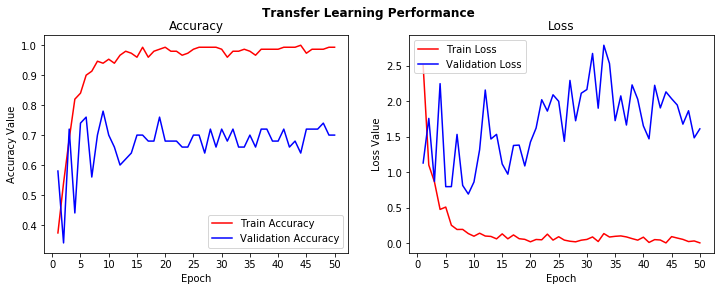

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Transfer Learning Performance", fontweight="bold", fontsize=12)
xrange = list(range(1,51))
ax1.plot(xrange, his.history["accuracy"], label="Train Accuracy", color="r")   #plot training accuracy 
ax1.plot(xrange, his.history["val_accuracy"], label="Validation Accuracy", color="b") #plot validation accuracy
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel("Accuracy Value")   #set y label
ax1.set_xlabel("Epoch")           #set x label
ax1.set_title("Accuracy")     
l1 = ax1.legend(loc="best")   #set legend

ax2.plot(xrange, his.history["loss"], label="Train Loss",color="r")   #plot loss graph
ax2.plot(xrange, his.history["val_loss"], label="Validation Loss", color="b")
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")

We can see that the above model overfits. Let's use image augmentation on the transfer learning model to improve the issue.

In [13]:
#augmentation configuration used for training
tr_datagen = ImageDataGenerator(rotation_range=40, rescale=1./255, zoom_range=0.2, width_shift_range=0.2, 
                                height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

v_datagen = ImageDataGenerator(rescale=1./255)  #normalization

tr_gen = tr_datagen.flow(train_images, train_lab_enc, batch_size=10)
v_gen = v_datagen.flow(validation_images, validation_lab_enc, batch_size=10)

Build classification layers and compile the model.

In [10]:
#Build classification layers 
modft = Sequential()
modft.add(vggm)   #add vgg16 model as base
modft.add(Dense(216, activation="relu"))
modft.add(Dropout(0.2))
modft.add(Dense(96, activation="relu"))
modft.add(Dropout(0.2))
modft.add(Dense(5, activation="softmax"))

#Compile the model
modft.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
modft.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 216)               1769688   
_________________________________________________________________
dropout_1 (Dropout)          (None, 216)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                20832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 485       
Total params: 16,505,693
Trainable params: 1,791,005
Non-trainable params: 14,714,688
__________________________________

Perform training on the dataset.

In [11]:
hisa = modft.fit_generator(tr_gen, steps_per_epoch=15, epochs=50, validation_data=v_gen, validation_steps=5)


Epoch 1/50
15/15 [==============================] - 22s 1s/step - loss: 2.8558 - accuracy: 0.1933 - val_loss: 1.6493 - val_accuracy: 0.2000
Epoch 2/50
15/15 [==============================] - 5s 310ms/step - loss: 1.5088 - accuracy: 0.3800 - val_loss: 1.1271 - val_accuracy: 0.4600
Epoch 3/50
15/15 [==============================] - 5s 303ms/step - loss: 1.4775 - accuracy: 0.4267 - val_loss: 0.8426 - val_accuracy: 0.5400
Epoch 4/50
15/15 [==============================] - 5s 304ms/step - loss: 1.3589 - accuracy: 0.4867 - val_loss: 0.9101 - val_accuracy: 0.6400
Epoch 5/50
15/15 [==============================] - 5s 311ms/step - loss: 1.1372 - accuracy: 0.5467 - val_loss: 1.2799 - val_accuracy: 0.6000
Epoch 6/50
15/15 [==============================] - 5s 315ms/step - loss: 1.1484 - accuracy: 0.5800 - val_loss: 0.9239 - val_accuracy: 0.7600
Epoch 7/50
15/15 [==============================] - 5s 307ms/step - loss: 0.8895 - accuracy: 0.6667 - val_loss: 1.0150 - val_accuracy: 0.6000
Epoch 8/

Plot the Loss and Accuracy graph.

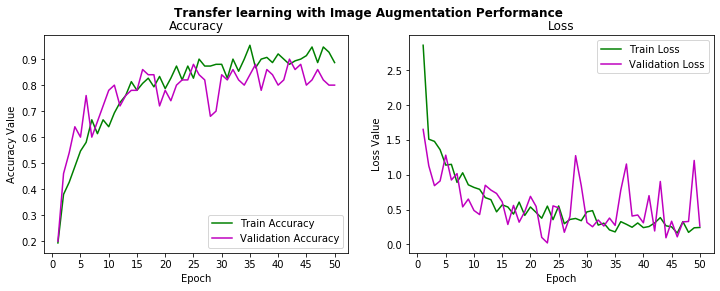

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Transfer learning with Image Augmentation Performance", fontweight="bold", fontsize=12)
xrange = list(range(1,51))
ax1.plot(xrange, hisa.history["accuracy"], label="Train Accuracy", color="g")
ax1.plot(xrange, hisa.history["val_accuracy"], label="Validation Accuracy", color="m")
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(xrange, hisa.history["loss"], label="Train Loss",color="g")
ax2.plot(xrange, hisa.history["val_loss"], label="Validation Loss", color="m")
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")


Let's save the model.

In [111]:
# modft.save("imgaugtest.h5")

We can see that the model with augmentation had an improvement in the validation accuracy and better fitting.
Next, we will proceed with finetuning the pre-trained network layers.

#### Fine Tuning of CNN

We will fine tune the model by unfreezing the last unconvolutional block.

In [8]:
vgg = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(IMG_DIM))
vggf = Model(vgg.input, Flatten()(vgg.layers[-1].output))  #flatten output layer

vggf.trainable = True
set_trainable = False

for layer in vggf.layers:
    if layer.name in ["block5_conv1"]:   #unfreeze block5_conv1 layers onwards
        set_trainable = True             
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
vggf.summary()   #summary of the trainable and non-trainable parameters

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

Layers trainable in the VGG model.

In [10]:
layers = [(layer, layer.name, layer.trainable) for layer in vggf.layers]      
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


Build classification layers and compile the model.

In [19]:
#Build classification layers 
mod = Sequential()

mod.add(vggf)   #add vgg16 model as base
mod.add(Dense(216, activation="relu"))
mod.add(Dropout(0.2))
mod.add(Dense(96, activation="relu"))
mod.add(Dropout(0.2))
mod.add(Dense(5, activation="softmax"))

#Compile the model
mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
mod.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_9 (Dense)              (None, 216)               1769688   
_________________________________________________________________
dropout_6 (Dropout)          (None, 216)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 96)                20832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 485       
Total params: 16,505,693
Trainable params: 8,870,429
Non-trainable params: 7,635,264
___________________________________

Perform training on the dataset.

In [20]:
hisb = mod.fit_generator(tr_gen, steps_per_epoch=15, epochs=50, validation_data=v_gen, validation_steps=5, shuffle = True)


Epoch 1/50
15/15 [==============================] - 7s 475ms/step - loss: 311.6001 - accuracy: 0.3333 - val_loss: 5.1832 - val_accuracy: 0.4800
Epoch 2/50
15/15 [==============================] - 6s 403ms/step - loss: 2.6385 - accuracy: 0.4533 - val_loss: 2.1260 - val_accuracy: 0.3200
Epoch 3/50
15/15 [==============================] - 6s 410ms/step - loss: 1.2709 - accuracy: 0.5000 - val_loss: 1.0729 - val_accuracy: 0.5600
Epoch 4/50
15/15 [==============================] - 6s 411ms/step - loss: 0.9383 - accuracy: 0.6467 - val_loss: 1.6869 - val_accuracy: 0.4200
Epoch 5/50
15/15 [==============================] - 6s 416ms/step - loss: 0.8511 - accuracy: 0.6533 - val_loss: 2.0819 - val_accuracy: 0.5200
Epoch 6/50
15/15 [==============================] - 6s 413ms/step - loss: 0.4148 - accuracy: 0.8600 - val_loss: 1.4437 - val_accuracy: 0.6400
Epoch 7/50
15/15 [==============================] - 6s 415ms/step - loss: 0.6183 - accuracy: 0.8533 - val_loss: 3.2368 - val_accuracy: 0.6000
Epoc

Plot the Loss and Accuracy graph.

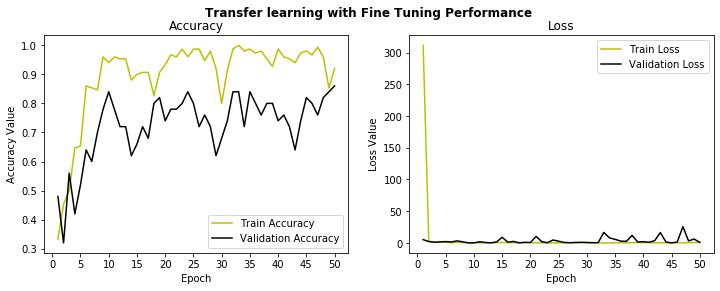

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Transfer learning with Fine Tuning Performance", fontweight="bold", fontsize=12)
xrange = list(range(1,51))
ax1.plot(xrange, hisb.history["accuracy"], label="Train Accuracy", color="y")
ax1.plot(xrange, hisb.history["val_accuracy"], label="Validation Accuracy", color="k")
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(xrange, hisb.history["loss"], label="Train Loss",color="y")
ax2.plot(xrange, hisb.history["val_loss"], label="Validation Loss", color="k")
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")

In [25]:
# mod.save("finetunetest.h5")

We have saved both models. Next, we will test the performance of the both models.

#### Testing with performance matrix

Load the test dataset for prediction.

In [29]:
#resizing testing dataset and spliting name of label according to their category
test_images = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test]
test_images = np.array(test_images)
test_labels = [w.split("\\")[0].split(".")[0].strip() for w in test]

#normalize the data
test_images_scaled = test_images.astype("float32")/255.0

In [35]:
#label encode to convert test labels to numerical values
le = LabelEncoder()
le.fit(test_labels)
test_lab_enc = le.transform(test_labels)     

Loading pre-trained model.

In [4]:
cnn = load_model("imgaugtest.h5")   #load image-augmented model

In [3]:
ftune = load_model("finetunetest.h5")   #load fine-tuned model

In [43]:
print("The classes are as follow:\n\n 0: balbasaur\n 1: charmander\n 2: mewtwo\n 3: pikachu\n 4: squirtle")

The classes are as follow:

 0: balbasaur
 1: charmander
 2: mewtwo
 3: pikachu
 4: squirtle


Using the test dataset for prediction.

In [38]:
test_lab_enc  #actual classes in the test dataset

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [32]:
predict = ftune.predict_classes(test_images_scaled, verbose=0)    #prediction of fine-tuned model

array([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 4, 2, 4, 4, 4, 4, 2, 4, 4, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 1], dtype=int64)

In [31]:
predictions = cnn.predict_classes(test_images_scaled, verbose=0)  #prediction of image-augmented model

array([3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 1], dtype=int64)

Performance Metrics of both models.

In [62]:
def metric(true_lab, pred_lab):
    
    print("Accuracy: {:.4f}".format(accuracy_score(true_lab, pred_lab)))
    print("Precision: {:.4f}".format(precision_score(true_lab, pred_lab,average="weighted")))
    print("Recall: {:.4f}".format(recall_score(true_lab, pred_lab,average="weighted")))
    print("F1 Score: {:.4f}".format(f1_score(true_lab, pred_lab,average="weighted")))

print("Performance Metrics of fine-tuned model:\n")

metric(test_lab_enc, predict)

Performance Metrics of fine-tuned model:

Accuracy: 0.8400
Precision: 0.8629
Recall: 0.8400
F1 Score: 0.8422


In [63]:
def metrics(true_lab, pred_lab):
    
    print("Accuracy: {:.4f}".format(accuracy_score(true_lab, pred_lab)))
    print("Precision: {:.4f}".format(precision_score(true_lab, pred_lab,average="weighted")))
    print("Recall: {:.4f}".format(recall_score(true_lab, pred_lab,average="weighted")))
    print("F1 Score: {:.4f}".format(f1_score(true_lab, pred_lab,average="weighted")))

print("Performance Metrics of image-augmented model:\n")

metrics(test_lab_enc, predictions)

Performance Metrics of image-augmented model:

Accuracy: 0.9600
Precision: 0.9667
Recall: 0.9600
F1 Score: 0.9608


Classification report of both models.

In [33]:
report = classification_report(y_true=test_lab_enc, y_pred=predict) 
print("Classification report of fine-tuned model:\n\n {}".format(report))


Classification report of fine-tuned model

               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.80      0.89        10
           2       0.71      1.00      0.83        10
           3       0.90      0.90      0.90        10
           4       0.70      0.70      0.70        10

    accuracy                           0.84        50
   macro avg       0.86      0.84      0.84        50
weighted avg       0.86      0.84      0.84        50



In [40]:
report = classification_report(y_true=test_lab_enc, y_pred=predictions) 
print("Classification report of image-augmented model:\n\n {}".format(report))


Classification report of image-augmented model

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        10
           3       1.00      0.90      0.95        10
           4       0.83      1.00      0.91        10

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.97      0.96      0.96        50



Confusion matrix of both models.

Fine-tuned model

In [56]:
ft = confusion_matrix(y_true=test_lab_enc, y_pred=predict)
ft

array([[ 8,  0,  1,  0,  1],
       [ 0,  8,  0,  0,  2],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  1,  9,  0],
       [ 0,  0,  2,  1,  7]], dtype=int64)

Text(0.5, 15.0, 'Ground Truth')

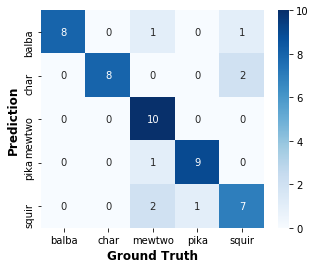

In [81]:
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(ft, annot=True, fmt="d", cmap="Blues")
labels = ["balba", "char", "mewtwo", "pika", "squir"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel("Prediction", fontweight="bold", fontsize=12)
ax.set_xlabel("Ground Truth", fontweight="bold", fontsize=12)

Image-augmented model

In [58]:
imaug = confusion_matrix(y_true=test_lab_enc, y_pred=predictions)
imaug

array([[10,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  1],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  0,  9,  1],
       [ 0,  0,  0,  0, 10]], dtype=int64)

Text(0.5, 15.0, 'Ground Truth')

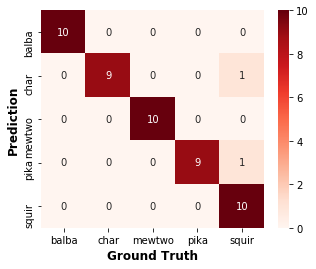

In [80]:
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(imaug, annot=True, fmt="d", cmap="Reds")
labels = ["balba", "char", "mewtwo", "pika", "squir"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel("Prediction", fontweight="bold", fontsize=12)
ax.set_xlabel("Ground Truth", fontweight="bold", fontsize=12)

Let's use the fine-tuned model to predict random images downloaded which are not in the test dataset.

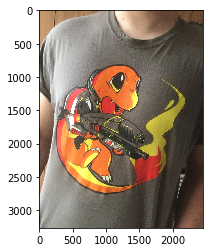

In [88]:
img = imread("char_test.jpeg")
npImg = np.array(img)
plt.imshow(Image.fromarray(npImg))

In [14]:
#load the image 
img = imread("char_test.jpeg")

#pre-processing the test image
image = cv2.resize(img, (150, 150))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

#classify the input image
pred = cnn.predict(image)  
print("The probabilities of all the classes: {}".format(pred))
idx = np.argmax(pred)
print("The index of the predicted (highest proba) class: {}".format(idx))
#The classes are in order accordance to the trained model(alphabetical)
pred = ["balbasaur", "charmander", "mewtwo", "pikachu", "squirtle"][idx]  
print("The predicted class is {}.".format(pred))


The probabilities of all the classes: [[3.5184200e-03 9.2323291e-01 7.2523803e-02 4.6355222e-04 2.6131619e-04]]
The index of the predicted (highest proba) class: 1
The predicted class is charmander.


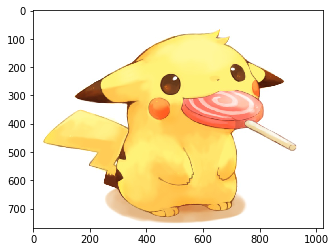

In [109]:
img = imread("pikachu_test.jpeg")
npImg = np.array(img)
plt.imshow(Image.fromarray(npImg))

In [25]:
#load the image 
im = imread("pikachu_test.jpeg")

#pre-processing the test image
ima = cv2.resize(im, (150, 150))
ima = ima.astype("float")/255.0
ima = img_to_array(ima)
ima = np.expand_dims(ima, axis=0)

#classify the input image
predict = ftune.predict(ima)  
print("The probabilities of all the classes: {}".format(predict))
idx = np.argmax(predict)
print("The index of the predicted (highest proba) class: {}".format(idx))
#The classes are in order accordance to the trained model(alphabetical)
predict = ["balbasaur", "charmander", "mewtwo", "pikachu", "squirtle"][idx]  
print("The predicted class is {}.".format(predict))

The probabilities of all the classes: [[1.4482633e-15 6.0090399e-10 8.4369827e-09 1.0000000e+00 2.4945783e-15]]
The index of the predicted (highest proba) class: 3
The predicted class is pikachu.


In [37]:
#load the image 
im = imread("mewt.jfif")

#pre-processing the test image
ima = cv2.resize(im, (150, 150))
ima = ima.astype("float")/255.0
ima = img_to_array(ima)
ima = np.expand_dims(ima, axis=0)

#classify the input image
predict = cnn.predict(ima)  
print("The probabilities of all the classes: {}".format(predict))
idx = np.argmax(predict)
print("The index of the predicted (highest proba) class: {}".format(idx))
#The classes are in order accordance to the trained model(alphabetical)
predict = ["balbasaur", "charmander", "mewtwo", "pikachu", "squirtle"][idx]  
print("The predicted class is {}.".format(predict))

The probabilities of all the classes: [[3.9553558e-10 6.6614365e-07 9.9999928e-01 8.2283680e-10 1.5609548e-09]]
The index of the predicted (highest proba) class: 2
The predicted class is mewtwo.
